In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import random
import matplotlib.pyplot as plt
import math
%matplotlib inline

C:\Users\nroy0\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Paper definitions:
Enhancer paper = "Enhancer Identification from DNA sequence using Transfer and Adversarial Deep Learning"  
triple GAN = "Triple Generative Adversarial Nets"

### Loading the data

In [2]:
def data_process_fn(sample):
    """
    Inputs:
        sample: (string) String of DNA data of length n, example: ACTGTA...
    Outputs:
        A numpy array of size n x 4 where A in the DNA sequence has been replace with [1 0 0 0], C with [0 1 0 0],
        G with [0 0 1 0] and T with [0 0 0 1].
    """
    mapping = tf.constant(["A", "C", "G", "T"])
    embeddings = tf.constant([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
        
    sample_split = tf.string_split([sample], '')
    lookup_table = tf.contrib.lookup.index_table_from_tensor(mapping = mapping, num_oov_buckets = 0)
    lookup_table.init.run()
    sample_indices = lookup_table.lookup(sample_split.values)
    encoded = tf.nn.embedding_lookup(embeddings, sample_indices)
    
    return encoded

    
def input_fn(data_file_names):
    """
    Inputs:
        data_file_names: (string/string array) List of files to be loaded. * can be used as a wildcard in file names.
    Outputs:
        Tensor flow dataset containing the data matrices from data_file_names
    """
    files = tf.data.Dataset.list_files(data_file_names)
#     dataset = files.interleave(lambda x: tf.data.TextLineDataset(x).map(data_process_fn), cycle_length = 1)
    dataset = files.interleave(lambda x: tf.data.TextLineDataset(x), cycle_length = 1)
    
    return dataset

In [ ]:
#Example of data loading - human positive samples

with  tf.Session() as sess:
    
    input_data_example = input_fn("Data/Human/positive_samples")
    iter = input_data_example.make_one_shot_iterator()
    val = iter.get_next()
    

### Scratchpad

In [ ]:

kernel_shape=[4,9]
input_channels = 1
num_kernels = 20

weights_shape = kernel_shape + [input_channels, num_kernels]
print(weights_shape)
print([1] + [2, 2] + [1])
print(int(500/8))

### Defining helper functions


In [24]:
def conv_layer(name_scope, input_tensor, num_kernels, kernel_shape,
               stride=1, padding="VALID", relu=True, lrelu=False,
               batch_normalize=False, batch_normalize_training=True, 
               name_suffix=None, batch_norm=False):
    """
    Return a convolution layer, possibly with a ReLU at the end.
    :param name_scope:   where the variables live
    :param input_tensor: of shape [batch, in_height, in_width, in_channels], e.g. [15 500 4 1]
    :param num_kernels:  number of kernels to use for this conv. layer
    :param kernel_shape: the shape of the kernel to use, [height, width]
    """
    name_suffix = name_suffix if name_suffix else ""
    
    #E.g. batch_size x 500x4x1 for the first input
    input_shape = input_tensor.get_shape().as_list()
    input_channels = input_shape[-1]
    
    #not really sure why I'm using the name_scope, I think it's mostly for presentation purposes
    with tf.name_scope(name_scope):
        
        weights_shape = kernel_shape + [input_channels, num_kernels]
        init_vals_weights = tf.truncated_normal(weights_shape, stddev=math.sqrt(2 / float(input_channels)))
        filter_weights = tf.Variable(init_vals_weights, name='weights'+name_suffix)
    
        biases = tf.Variable(tf.zeros([num_kernels]), name='biases'+name_suffix)
        
        #Define a convolutional layer
        layer = tf.nn.conv2d(input_tensor, filter_weights, strides=[1, stride, stride, 1], padding=padding) + biases
        
        #Add batch normalisation if specified
        #TODO: is_training always True?
        if batch_norm:
            layer = tf.contrib.layers.batch_norm(inputs = layer, center=True, scale=True, is_training=True)
            
        #Add (leaky) ReLU if specified
        if relu and lrelu:
            layer = tf.nn.leaky_relu(layer, name="lrelu_"+name_suffix)
        elif relu:
            layer = tf.nn.relu(layer, name="relu_"+name_suffix)
            
        return layer

def conv_max_forward_reverse(name_scope, input_tensor, num_kernels, kernel_shape,
                             stride=1, padding='VALID', relu=True, lrelu=False, name_suffix=None):
    """
    Returns a convolution layer
    """
    name_suffix = name_suffix if name_suffix else ""
    
    input_shape = input_tensor.get_shape().as_list()
    input_channels = input_shape[-1] # number of input channels
    with tf.name_scope(name_scope):
        shape = kernel_shape + [input_channels, num_kernels]
        initer = tf.truncated_normal(shape, stddev=math.sqrt(2 / float(input_channels)))
        weights = tf.Variable(initer, name='weights')
        num_kernels = weights.get_shape()[3]
        biases = tf.Variable(tf.zeros([num_kernels]), name='biases')

        # If one component of shape is the special value -1, the size of that dimension is computed
        #  so that the total size remains constant.
        # In our case: -1 is inferred to be input_channels * out_channels:
        new_weights_shape = [-1] + kernel_shape + [1]
        w_image = tf.reshape(weights, new_weights_shape)
        tf.summary.image(name_scope + "_weights_im", w_image, weights.get_shape()[3])
        forward_conv = tf.nn.conv2d(input_tensor, weights, strides=[1, stride, stride, 1], padding=padding,
                               name="forward_conv") + biases
        # for reverse complement: reverse in dimension 0 and 1:
        rev_comp_weights = tf.reverse(weights, [0, 1], name="reverse_weights")
        reverse_conv = tf.nn.conv2d(input_tensor, rev_comp_weights,
                                    strides=[1, stride, stride, 1], padding=padding,
                                    name="reverse_conv") + biases
        # takes the maximum between the forward weights and the rev.-comp.-weights:
        max_conv = tf.maximum(forward_conv, reverse_conv, name="conv1")
        if relu and lrelu:
            return tf.nn.leaky_relu(max_conv, name="lrelu_"+name_suffix)
        elif relu:
            return tf.nn.relu(max_conv, name="relu_"+name_suffix)
        else:
            return max_conv
        
def max_pool_layer(name_scope, input_tensor, pool_size, strides = None, padding="SAME"):
    """
    Return a max pool layer.
    """
    if not strides:
        strides = [1] + pool_size + [1]
       
    #TODO: is name_scope really needed?
    with tf.name_scope(name_scope):
        layer = tf.nn.max_pool(input_tensor, [1] + pool_size + [1], strides=strides, padding=padding)
        return layer


def dropout_layer(name_scope, input_tensor, keep_prob=0.5):
    """
    Return a dropout layer.
    """
    #TODO: is name_scope really needed?
    with tf.name_scope(name_scope):
        return tf.nn.droupout(input_tensor, keep_prob)
    
def flatten(x):
    """
    Returns a flat (one-dimensional) version of the input
    """
    x_shape = x.get_shape().as_list()
    return tf.reshape(x, [-1, np.product(x_shape[1:])])

In [11]:
# def classifier(dna_sequence):
#     """
#     Return the same classifier, with architecture the same as they used in Enhancer paper.
#     """
#     # 20 filters, each of size batch x 9x4x1
#     # TODO: make a reverse filter conv layer like in the Enhancer paper 
#     with tf.variable_scope('classifier') as scope:
#         if (reuse):
#             tf.get_variable_scope().reuse_variables()
        
        
#         l1 =  conv_max_forward_reverse(data, name_scope="layer1", num_kernels=20, kernel_shape=[4, 9], relu=True)
    #TODO finish

def discriminator(dna_sequence, label_one_hot=None, reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
            
        # TODO: make a reverse filter conv layer like in the Enhancer paper 

        # convolutional + pooling #1
        l1 = conv_layer(name_scope="conv1", input_tensor=dna_sequence, num_kernels=20, 
                        kernel_shape=[4, 9], relu=True)
        l2 = max_pool_layer(name_scope="pool1", input_tensor=l1, pool_size=[1, 3])

        # convolutional + pooling #2
        l3 = conv_layer(name_scope="conv2", input_tensor=l2, num_kernels=30, kernel_shape=[1, 5])
        l4 = max_pool_layer(name_scope="pool2", input_tensor=l3, pool_size=[1, 4])

        # convolutional + pooling #3
        l5 = conv_layer(name_scope="conv3", input_tensor=l4, num_kernels=40, kernel_shape=[1, 3])
        l6 = max_pool_layer(name_scope="pool3", input_tensor=l5, pool_size=[1, 4])

        flat = flatten(l6)
        # fully connected layers
        l7 = tf.layers.dense(inputs=flat, units=90)
        l8 = tf.layers.dense(inputs=l7, units=45)

        logits = tf.layers.dense(inputs=l8, units=2)
        
#     return tf.nn.softmax(logits, name="softmax_tensor")
    return logits
    
def generator(noise_vector, batch_size, label_one_hot=None, reuse=False):
    with tf.variable_scope('generator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        g_dim = 64 #Number of filters of first layer of generator 
        c_dim = 1 #dimensionality of the output
        s = 500 #Final length of the sequence
        
        #We want to slowly upscale the sequence, so these values should help
        # to make that change gradual
        s2, s4, s8, s16 = int(s/2), int(s/4), int(s/8), int(s/16)
                                                                  
        width = 4 #because we have 4 letters: ATCG
        
        #this is a magic number which I'm not sure what means yet
        magic_number = 5
        
        h0 = tf.reshape(noise_vector, [batch_size, int(width/4), s16+1, magic_number])
        h0 = tf.nn.relu(h0)
        #Dimensions of h0 = batch_size x 1 x 31 x magic_number

        #First DeConv Layer
        output1_shape = [batch_size, int(width/2), s8+1, g_dim*4]
        W_conv1 = tf.get_variable('g_wconv1', [5, 5, output1_shape[-1], int(h0.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv1 = tf.get_variable('g_bconv1', [output1_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv1 = tf.nn.conv2d_transpose(value=h0, filter=W_conv1, output_shape=output1_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME', name="H_conv1") + b_conv1
        H_conv1 = tf.contrib.layers.batch_norm(inputs = H_conv1, center=True, scale=True, is_training=True, 
                                               scope="g_bn1")
        H_conv1 = tf.nn.relu(H_conv1)
        #Dimensions of H_conv1 = batch_size x 1 x 62 x 256

        
        
        #Second DeConv Layer
        output2_shape = [batch_size, int(width/2), s4, g_dim*2]
        W_conv2 = tf.get_variable('g_wconv2', [5, 5, output2_shape[-1], int(H_conv1.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv2 = tf.get_variable('g_bconv2', [output2_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv2 = tf.nn.conv2d_transpose(H_conv1, W_conv2, output_shape=output2_shape, 
                                         strides=[1, 1, 2, 1], padding='SAME') + b_conv2
        H_conv2 = tf.contrib.layers.batch_norm(inputs = H_conv2, center=True, scale=True, is_training=True, 
                                               scope="g_bn2")
        H_conv2 = tf.nn.relu(H_conv2)
        #Dimensions of H_conv2 = batch_size x 2 x 124 x 128

        
        #Third DeConv Layer
        output3_shape = [batch_size, width, s2, g_dim*1]
        W_conv3 = tf.get_variable('g_wconv3', [5, 5, output3_shape[-1], int(H_conv2.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv3 = tf.get_variable('g_bconv3', [output3_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv3 = tf.nn.conv2d_transpose(H_conv2, W_conv3, output_shape=output3_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv3
        H_conv3 = tf.contrib.layers.batch_norm(inputs = H_conv3, center=True, scale=True, is_training=True, 
                                               scope="g_bn3")
        H_conv3 = tf.nn.relu(H_conv3)
        #Dimensions of H_conv3 = batch_size x 4 x 248 x 64

        
        #Fourth DeConv Layer
        output4_shape = [batch_size, width, s, c_dim]
        W_conv4 = tf.get_variable('g_wconv4', [1, 2, output4_shape[-1], int(H_conv3.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv4 = tf.get_variable('g_bconv4', [output4_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv4 = tf.nn.conv2d_transpose(H_conv3, W_conv4, output_shape=output4_shape, 
                                         strides=[1, 1, 2, 1], padding='VALID') + b_conv4
        H_conv4 = tf.nn.tanh(H_conv4)

        #Dimensions of H_conv4 = batch_size x 4 x 500 x 1
    return H_conv4

In [36]:
def classifier(dna_sequence, label_one_hot=None, reuse=False):
    with tf.variable_scope('classifier') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
            
        # TODO: make a reverse filter conv layer like in the Enhancer paper 

        # convolutional + pooling #1
        l1 = conv_max_forward_reverse(name_scope="conv1", input_tensor=dna_sequence, num_kernels=20, 
                        kernel_shape=[4, 9], relu=True)
        l2 = max_pool_layer(name_scope="pool1", input_tensor=l1, pool_size=[1, 3])

        # convolutional + pooling #2
        l3 = conv_max_forward_reverse(name_scope="conv2", input_tensor=l2, num_kernels=30, kernel_shape=[1, 5])
        l4 = max_pool_layer(name_scope="pool2", input_tensor=l3, pool_size=[1, 4])

        # convolutional + pooling #3
        l5 = conv_max_forward_reverse(name_scope="conv3", input_tensor=l4, num_kernels=40, kernel_shape=[1, 3])
        l6 = max_pool_layer(name_scope="pool3", input_tensor=l5, pool_size=[1, 4])

        flat = flatten(l6)
        # fully connected layers
        l7 = tf.layers.dense(inputs=flat, units=90)
        l8 = tf.layers.dense(inputs=l7, units=45)

        logits = tf.layers.dense(inputs=l8, units=2)
        
    return tf.argmax(logits, axis=1, name="softmax_tensor")
#     return logits

### Show a sample sequence

(4, 500)


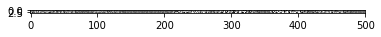

In [12]:
tf.reset_default_graph()
sess = tf.Session()

z_dimensions = 160
z_test_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])
sample_sequence = generator(z_test_placeholder, 1)
test_z = np.random.normal(-1, 1, [1,z_dimensions])

train_writer = tf.summary.FileWriter('./train',
                                      sess.graph)

sess.run(tf.global_variables_initializer())
temp = (sess.run(sample_sequence, feed_dict={z_test_placeholder: test_z}))

my_seq = temp.squeeze()

print(my_seq.shape)
plt.imshow(my_seq, cmap='gray_r')
plt.show()
sess.close()



### Check whether the discriminator is working

In [13]:
batch_size = 16

#Since we changed our batch size (from 1 to 16), we need to reset our Tensorflow graph
tf.reset_default_graph() 
sess = tf.Session()

#Placeholder for input images to the discriminator
x_placeholder = tf.placeholder("float", shape = [None, 4, 500, 1])
#Placeholder for input noise vectors to the generator
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions]) 


#Dx will hold discriminator prediction probabilities for the real enhancer sequences
Dx = discriminator(x_placeholder) 
#Gz holds the generated sequences
Gz = generator(z_placeholder, batch_size, z_dimensions) 
#Dg will hold discriminator prediction probabilities for generated images
Dg = discriminator(Gz, reuse=True)

print(Dx, Gz, Dg)
sess.close()

Tensor("discriminator/dense_2/BiasAdd:0", shape=(?, 2), dtype=float32) Tensor("generator/Tanh:0", shape=(16, 4, 500, 1), dtype=float32) Tensor("discriminator_1/dense_2/BiasAdd:0", shape=(16, 2), dtype=float32)


## checking the classifier


In [39]:
batch_size = 16

#Since we changed our batch size (from 1 to 16), we need to reset our Tensorflow graph
tf.reset_default_graph() 
sess = tf.Session()

#Placeholder for input images to the discriminator
x_placeholder = tf.placeholder("float", shape = [None, 4, 500, 1])
#Placeholder for input noise vectors to the generator
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions]) 


#Dx will hold discriminator prediction probabilities for the real enhancer sequences
Dx = classifier(x_placeholder) 
#Gz holds the generated sequences
Gz = generator(z_placeholder, batch_size, z_dimensions) 
#Dg will hold discriminator prediction probabilities for generated images
Dg = classifier(Gz, reuse=True)

print(Dx, Gz, Dg)
sess.close()

Tensor("softmax_tensor:0", shape=(?,), dtype=int64) Tensor("generator/Tanh:0", shape=(16, 4, 500, 1), dtype=float32) Tensor("softmax_tensor_1:0", shape=(16,), dtype=int64)


# Note: below is taken from [the tutorial here](https://github.com/uclaacmai/Generative-Adversarial-Network-Tutorial.git) (and modified)

### Assemble components (discriminator, generator, classifier) for triple GAN

In [26]:
batch_size = 16

#Since we changed our batch size (from 1 to 16), we need to reset our Tensorflow graph
tf.reset_default_graph() 
sess = tf.Session()

#Placeholder for input images to the discriminator
x_placeholder = tf.placeholder("float", shape = [None, 4, 500, 1])
#Placeholder for input noise vectors to the generator
z_dimensions = 160
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions]) 


#Dx will hold discriminator prediction probabilities for the real enhancer sequences
Dx = discriminator(x_placeholder) 
#Gz holds the generated sequences
Gz = generator(z_placeholder, batch_size, z_dimensions) 
#Dg will hold discriminator prediction probabilities for generated images
Dg = discriminator(Gz, reuse=True)
sess.close()


### Specify loss

In [ ]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg))) # ensure forward compatibility: function needs to have logits and labels args explicitly used

d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))
d_loss = d_loss_real + d_loss_fake


### Specify optimizers

In [ ]:
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'discriminator' in var.name]
g_vars = [var for var in tvars if 'generator' in var.name]
print("Discriminator has %d variables to train." % len(d_vars))
print("Generator has %d variables to train. " % len(g_vars))
print("Reusing variable scope? %r" % tf.get_variable_scope().reuse)
adam = tf.train.AdamOptimizer()
trainerD = adam.minimize(d_loss, var_list=d_vars)
trainerG = adam.minimize(g_loss, var_list=g_vars)

### Train the stuff

In [ ]:
z_dimensions = 160
batch_size = 16
iterations = 3000

sess = tf.Session()
sess.run(tf.global_variables_initializer())
with sess.as_default():
    data = input_fn("Data/Human/positive_samples")
    batched_dataset = data.batch(batch_size)
    batched_dataset_iterator = batched_dataset.make_one_shot_iterator()
    next_element = batched_dataset_iterator.get_next()

    ####### Specify discriminator and generator ######
    #Dx will hold discriminator prediction probabilities for the real enhancer sequences
    Dx = discriminator(next_element) 
    #Gz holds the generated sequences
    z_batch = np.random.normal(-1, 1, size=[1, z_dimensions])
    Gz = generator(z_batch, batch_size, z_dimensions) 
    #Dg will hold discriminator prediction probabilities for generated images
    Dg = discriminator(Gz, reuse=True)
    
    ###### Specify losses ######
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg))) # ensure forward compatibility: function needs to have logits and labels args explicitly used
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))
    d_loss = d_loss_real + d_loss_fake
    
    ###### Specify optimizers ######
    tvars = tf.trainable_variables()
    d_vars = [var for var in tvars if 'discriminator' in var.name]
    g_vars = [var for var in tvars if 'generator' in var.name]
    print("Discriminator has %d variables to train." % len(d_vars))
    print("Generator has %d variables to train. " % len(g_vars))
    print("Reusing variable scope? %r" % tf.get_variable_scope().reuse)
    adam = tf.train.AdamOptimizer()
    trainerD = adam.minimize(d_loss, var_list=d_vars)
    trainerG = adam.minimize(g_loss, var_list=g_vars)

    ###### Actually run the training
    iterations=3000
    for i in range(iterations):
        z_batch = np.random.normal(-1, 1, size=[batch_size, z_dimensions])
        real_seq_batch = batched_dataset_iterator.get_next()

#         real_seq_batch = np.reshape(real_seq_batch[0], [batch_size, 4, 500, 1])
        _,dLoss = sess.run([trainerD, d_loss],feed_dict={z_placeholder:z_batch,x_placeholder:real_seq_batch}) #Update the discriminator
        _,gLoss = sess.run([trainerG, g_loss],feed_dict={z_placeholder:z_batch}) #Update the generator 